# This notebook contains:
* Arrays of rain rate intensity, frequency and HIM8 BT from ungridded files (redo)
* Code to calculate the mean channel 13 brightness temp using bathymetry to mask land vs ocean, for radar domains
* Diurnal cycle plots for there three outputs

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
from scipy.stats import circmean

# Calculate Himawari diurnal cycles:
* Read in files

In [67]:
# read in bathymetry files
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

# read in satellite files
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/himawari_regridded_files"
files = him8_files(directory)

# first for climatology, barra not included
# function to calculate mean brightness temperature for the entire rodar domain + for bathymetry>0 and <0 requirements
def read_netcdf_him8(file_path):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        # radar site boundaries
        data_towns = ds.ch13BT.sel(lat=slice(-20.768799,-18.065369),lon=slice(145.10834,147.99347))
        data_cairns = ds.ch13BT.sel(lat=slice(-18.165955,-15.463379),lon=slice(144.26343,147.1026))
        data_willis = ds.ch13BT.sel(lat=slice(-17.636353,-14.93396),lon=slice(148.54926,151.37994))
        # select land vs ocean for cairns and townsville
        bathymetry_towns = ds_bath["z"].sel(x=data_towns.lon,y=data_towns.lat,method="nearest")
        bathymetry_cairns = ds_bath["z"].sel(x=data_cairns.lon,y=data_cairns.lat,method="nearest")
        
        bathymetry_towns_land = bathymetry_towns> 0 
        bathymetry_cairns_land = bathymetry_cairns> 0 
        
        bathymetry_towns_ocean = bathymetry_towns<= 0 
        bathymetry_cairns_ocean = bathymetry_cairns<= 0 
        
        land_towns = xr.where(bathymetry_towns_ocean, np.nan, data_towns)
        land_cairns = xr.where(bathymetry_cairns_ocean, np.nan, data_cairns)
        ocean_towns = xr.where(bathymetry_towns_land, np.nan, data_towns)
        ocean_cairns = xr.where(bathymetry_cairns_land, np.nan, data_cairns)
        
        # calculate mean
        mean_towns_land = land_towns.groupby(land_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_cairns_land = land_cairns.groupby(land_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_towns_ocean = ocean_towns.groupby(ocean_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_cairns_ocean = ocean_cairns.groupby(ocean_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_willis = data_willis.groupby(data_willis.time.dt.hour).mean(dim=["lat","lon","time"])  
    return mean_towns_land, mean_cairns_land,mean_towns_ocean,mean_cairns_ocean,mean_willis

In [68]:
mean_towns_land,mean_cairns_land,mean_towns_ocean,mean_cairns_ocean,mean_willis = read_netcdf_him8(files)

In [ ]:
%%time
h8_towns_land = mean_towns_land.compute()
h8_cairns_land = mean_cairns_land.compute()
h8_towns_ocean = mean_towns_ocean.compute()
h8_cairns_ocean = mean_cairns_ocean.compute()
h8_willis = mean_willis.compute()

In [79]:
# change to aest
h8towns_land = np.roll(h8_towns_land,shift=10)
h8cairns_land = np.roll(h8_cairns_land,shift=10)
h8towns_ocean = np.roll(h8_towns_ocean,shift=10)
h8cairns_ocean = np.roll(h8_cairns_ocean,shift=10)
h8willis_ocean = np.roll(h8_willis,shift=10)

In [89]:
# save arrays
# np.save('/home/563/ac9768/himawari_regridded_files/h8_clim_willis_ocean.npy', h8willis_ocean)

In [116]:
# read in barra files for wind regimes
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
def read_netcdf_him8(file_path,barra_site,wdir1,wdir2,ne=None,towns=None,cairns=None):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        # barra conditions
        ds_barra = barra_site.sortby('time') 
        ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
        barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
        winds = barra.wind_dir.compute()
        if ne==True:
            wind_dir = winds[(winds>=wdir1)&(winds<=wdir2)]
        else:
            wind_dir = winds[(winds>wdir1)&(winds<=wdir2)]
        wind_times = wind_dir.time.values

        if towns==True:
            data_towns = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-20.768799,-18.065369),lon=slice(145.10834,147.99347))
            bathymetry_towns = ds_bath["z"].sel(x=data_towns.lon,y=data_towns.lat,method="nearest")
            bathymetry_towns_land = bathymetry_towns> 0 
            bathymetry_towns_ocean = bathymetry_towns<= 0 
            land_towns = xr.where(bathymetry_towns_ocean, np.nan, data_towns)
            ocean_towns = xr.where(bathymetry_towns_land, np.nan, data_towns)
            mean_land = land_towns.groupby(land_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
            mean_ocean = ocean_towns.groupby(ocean_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        elif cairns==True:
            data_cairns = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-18.165955,-15.463379),lon=slice(144.26343,147.1026))
            bathymetry_cairns = ds_bath["z"].sel(x=data_cairns.lon,y=data_cairns.lat,method="nearest")
            bathymetry_cairns_land = bathymetry_cairns> 0 
            bathymetry_cairns_ocean = bathymetry_cairns<= 0 
            land_cairns = xr.where(bathymetry_cairns_ocean, np.nan, data_cairns)
            ocean_cairns = xr.where(bathymetry_cairns_land, np.nan, data_cairns)
            mean_land = land_cairns.groupby(land_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
            mean_ocean = ocean_cairns.groupby(ocean_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        else:
            data_willis = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-17.636353,-14.93396),lon=slice(148.54926,151.37994))
            mean_land = 1
            mean_ocean = data_willis.groupby(data_willis.time.dt.hour).mean(dim=["lat","lon","time"])  
    return mean_land,mean_ocean

In [149]:
mean_land,mean_ocean = read_netcdf_him8(files,barra_willis,270,360,ne=False,towns=False,cairns=False)

In [150]:
# h8_reg_land = mean_land.compute()
h8_reg_ocean = mean_ocean.compute()

In [151]:
# change to aest
# h8_reg_land_aest = np.roll(h8_reg_land,shift=10)
h8_reg_ocean_aest = np.roll(h8_reg_ocean,shift=10)

In [152]:
# save arrays
# np.save('/home/563/ac9768/himawari_regridded_files/h8_nw_cairns_land.npy', h8_reg_land_aest)
np.save('/home/563/ac9768/himawari_regridded_files/h8_nw_willis_ocean.npy', h8_reg_ocean_aest)

# Calculate radar diurnal cycles

# Plotting function

In [186]:
def diurnal_cycle_plot(title,bt_min,bt_max,f_max,rr_max,
                       h8_towns_land,h8_cairns_land,h8_towns_ocean,h8_cairns_ocean,h8_willis_ocean,
                      raf_towns_land,raf_cairns_land,raf_towns_ocean,raf_cairns_ocean,raf_willis_ocean,
                      rai_towns_land,rai_cairns_land,rai_towns_ocean,rai_cairns_ocean,rai_willis_ocean):
    # layout of plots
    fig,ax = plt.subplots(3,2, figsize=[10,10])
    fig.patch.set_facecolor('white')
    fig.suptitle(title,y=1.02,fontsize=25)
    fig.tight_layout()
    sns.set_theme(style="whitegrid")
    # create titles for columns
    ax[0,0].set_title('Land',fontsize=15)
    ax[0,1].set_title('Ocean',fontsize=15)
    # create yaxis labels
    ax[0,0].set_ylabel('Channel 13 Brightness Temperature (K)')
    ax[0,0].set_ylim(bt_min,bt_max)
    ax[0,0].invert_yaxis()
    ax[0,1].set_ylim(bt_min,bt_max)
    ax[0,1].invert_yaxis()
    ax[1,0].set_ylabel('Rain Rate Frequency (%)')
    ax[1,0].set_ylim(0,f_max)
    ax[1,1].set_ylim(0,f_max)
    ax[2,0].set_ylabel('Rain Rate Intensity (mm/h)')
    ax[2,0].set_ylim(0,rr_max)
    ax[2,1].set_ylim(0,rr_max)
    # create xaxis labels
    ax[2,0].set_xlabel('Hour (AEST)')
    ax[2,1].set_xlabel('Hour (AEST)')
    ax[0,0].set_xlim(0,23) 
    ax[0,1].set_xlim(0,23) 
    ax[1,0].set_xlim(0,23) 
    ax[1,1].set_xlim(0,23) 
    ax[2,0].set_xlim(0,23) 
    ax[2,1].set_xlim(0,23) 
    xticks = ["0","3","6","9","12","15","18","21"]
    ax[0,0].set_xticks(np.arange(0,24,3),xticks)
    ax[0,1].set_xticks(np.arange(0,24,3),xticks)
    ax[1,0].set_xticks(np.arange(0,24,3),xticks)
    ax[1,1].set_xticks(np.arange(0,24,3),xticks)
    ax[2,0].set_xticks(np.arange(0,24,3),xticks)
    ax[2,1].set_xticks(np.arange(0,24,3),xticks)
    # add gridlines
    ax[0,0].grid(alpha=0.5) 
    ax[0,1].grid(alpha=0.5) 
    ax[0,1].set_facecolor('lightgray')
    ax[1,0].grid(alpha=0.5) 
    ax[1,1].grid(alpha=0.5) 
    ax[1,1].set_facecolor('lightgray')
    ax[2,0].grid(alpha=0.5) 
    ax[2,1].grid(alpha=0.5)
    ax[2,1].set_facecolor('lightgray')

    # plot data
    # himawari
    ax[0,0].plot(np.arange(0,24,1),h8_towns_land,linewidth=3,color='teal',label="Townsville")
    ax[0,0].plot(np.arange(0,24,1),h8_cairns_land,linewidth=3,color='magenta',label="Cairns")
    ax[0,1].plot(np.arange(0,24,1),h8_towns_ocean,linewidth=3,color='teal',label="Townsville")
    ax[0,1].plot(np.arange(0,24,1),h8_cairns_ocean,linewidth=3,color='magenta',label="Cairns")
    ax[0,1].plot(np.arange(0,24,1),h8_willis_ocean,linewidth=3,color='navy',label="Willis Island")
    ax[0,1].legend(bbox_to_anchor=(1, 1.4),)
    # rain rate frequency
    ax[1,0].plot(np.arange(0,24,1),raf_towns_land,linewidth=3,color='teal')
    ax[1,0].plot(np.arange(0,24,1),raf_cairns_land,linewidth=3,color='magenta')
    ax[1,1].plot(np.arange(0,24,1),raf_towns_ocean,linewidth=3,color='teal')
    ax[1,1].plot(np.arange(0,24,1),raf_cairns_ocean,linewidth=3,color='magenta')
    ax[1,1].plot(np.arange(0,24,1),raf_willis_ocean,linewidth=3,color='navy')
    # rain rate intensity (including raining times)
    ax[2,0].plot(np.arange(0,24,1),rai_towns_land,linewidth=3,color='teal')
    ax[2,0].plot(np.arange(0,24,1),rai_cairns_land,linewidth=3,color='magenta')
    ax[2,1].plot(np.arange(0,24,1),rai_towns_ocean,linewidth=3,color='teal')
    ax[2,1].plot(np.arange(0,24,1),rai_cairns_ocean,linewidth=3,color='magenta')
    ax[2,1].plot(np.arange(0,24,1),rai_willis_ocean,linewidth=3,color='navy')
    return

In [157]:
# read in H8 arrays to plot (these arrays have been produced for aest time)
# clim
h8towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_towns_land.npy')
h8cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_cairns_land.npy')
h8towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_towns_ocean.npy')
h8cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_cairns_ocean.npy')
h8willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_clim_willis_ocean.npy')
# ne
h8_ne_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_towns_land.npy')
h8_ne_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_towns_ocean.npy')
h8_ne_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_cairns_land.npy')
h8_ne_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_cairns_ocean.npy')
h8_ne_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_ne_willis_ocean.npy')
# se
h8_se_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_towns_land.npy')
h8_se_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_towns_ocean.npy')
h8_se_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_cairns_land.npy')
h8_se_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_cairns_ocean.npy')
h8_se_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_se_willis_ocean.npy')
# sw
h8_sw_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_towns_land.npy')
h8_sw_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_towns_ocean.npy')
h8_sw_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_cairns_land.npy')
h8_sw_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_cairns_ocean.npy')
h8_sw_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_sw_willis_ocean.npy')
# nw
h8_nw_towns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_towns_land.npy')
h8_nw_towns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_towns_ocean.npy')
h8_nw_cairns_land = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_cairns_land.npy')
h8_nw_cairns_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_cairns_ocean.npy')
h8_nw_willis_ocean = np.load('/home/563/ac9768/himawari_regridded_files/h8_nw_willis_ocean.npy')

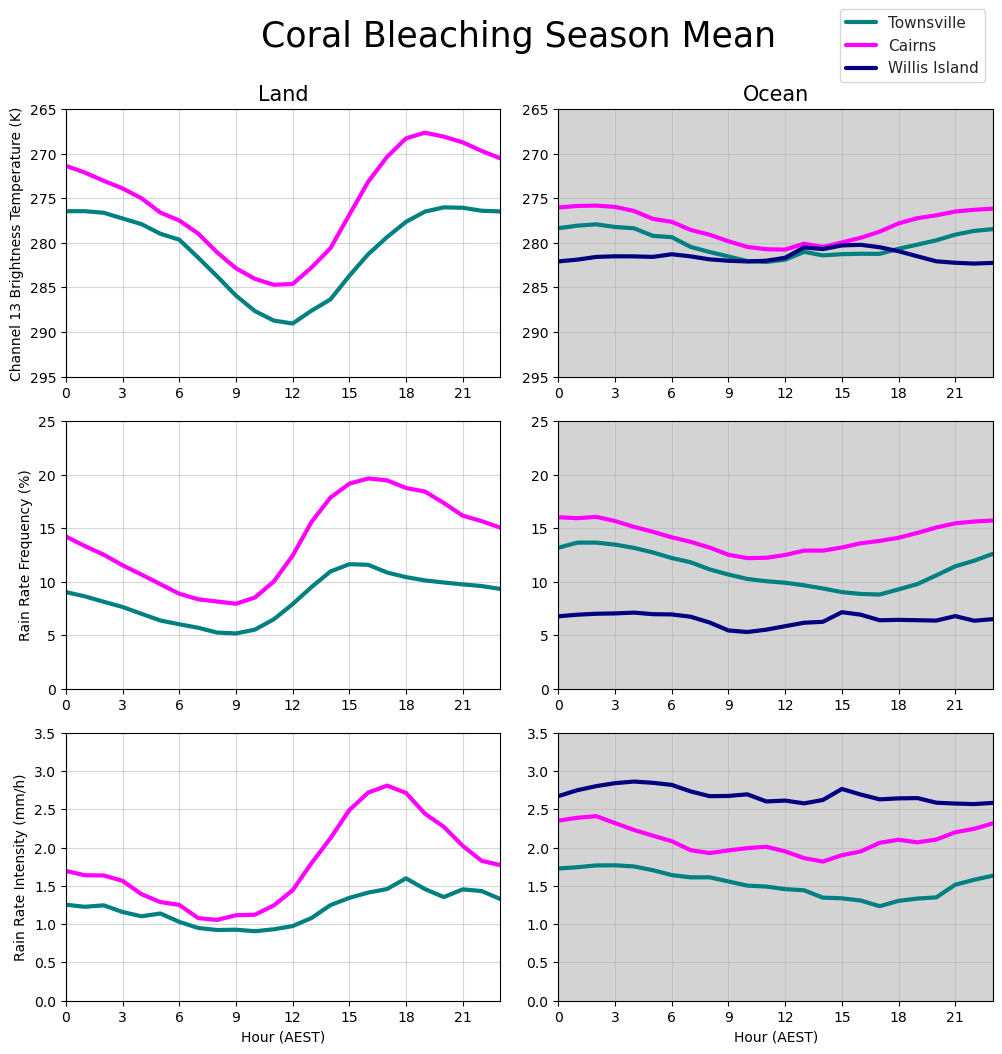

In [187]:
diurnal_cycle_plot('Coral Bleaching Season Mean',265,295,25,3.5,
                       h8towns_land,h8cairns_land,h8towns_ocean,h8cairns_ocean,h8willis_ocean,
                      rr_land_Tf,rr_land_Cf,rr_ocean_Tf,rr_ocean_Cf,rr_willisf,
                      rr_land_T,rr_land_C,rr_ocean_T,rr_ocean_C,rr_willis)

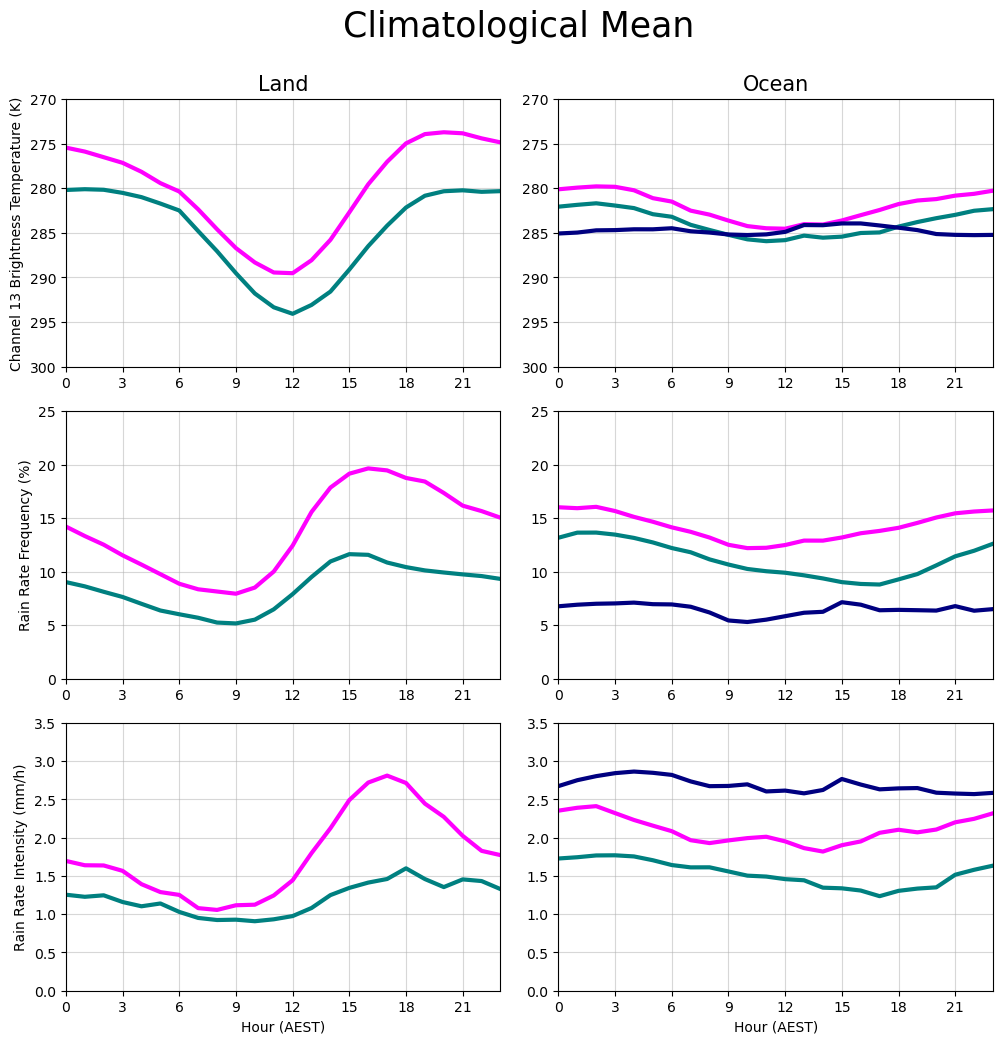

In [84]:
diurnal_cycle_plot('Climatological Mean',270,300,25,3.5,
                       bt_land_Tm,bt_land_Cm,bt_ocean_Tm,bt_ocean_Cm,bt_willism,
                      rr_land_Tf,rr_land_Cf,rr_ocean_Tf,rr_ocean_Cf,rr_willisf,
                      rr_land_T,rr_land_C,rr_ocean_T,rr_ocean_C,rr_willis)

# original plots

(280.0, 300.0)

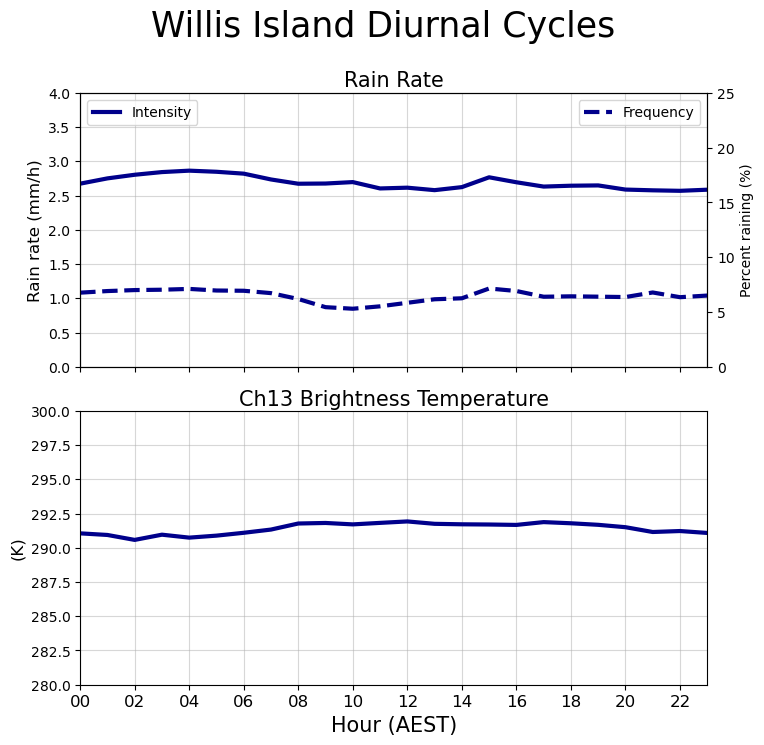

In [69]:
fig,ax = plt.subplots(2,1, figsize=[7,7])
fig.patch.set_facecolor('white')
fig.suptitle('Willis Island Diurnal Cycles',y=1.02,fontsize=25)
fig.tight_layout()

# ax[0].plot(np.arange(0,24,1),rr_land_T,linewidth=3,color="green",label='Land')
ax[0].plot(np.arange(0,24,1),rr_willis,linewidth=3,color="darkblue",linestyle='-',label='Intensity')
ax0 = ax[0].twinx()
ax0.set_ylabel('Percent raining (%)')
# ax0.plot(np.arange(0,24,1),rr_land_Tf,linewidth=3,color="green",linestyle='--',label='Land')
ax0.plot(np.arange(0,24,1),rr_willisf,linewidth=3,color="darkblue",linestyle='--',label='Frequency')

# ax[1].plot(np.arange(0,24,1),bt_land_T,linewidth=3,color="green",label='Land')
ax[1].plot(np.arange(0,24,1),bt_willis,linewidth=3,color="darkblue",linestyle='-',label='Ocean')

# ax[2].plot(np.arange(0,24,1),bt_willis,linewidth=3,color="royalblue")

# valid_indices = np.where(~np.isnan(rr_willisf))[0]
# ax0.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(rr_willisf)[valid_indices[14:16]], linestyle='--',linewidth=3,color="grey",label='Invalid data')
# ax0.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(rr_willisf)[valid_indices[18:22]], linestyle='--',linewidth=3,color="grey")
ax[0].set_xlim(0,23)
ax[1].set_xlim(0,23)
# ax[2].set_xlim(0,23)

ax[0].legend(loc='upper left')#loc='lower right',bbox_to_anchor=(1, 1))
ax0.legend(loc='upper right')
# ax[1].legend(loc='upper left')
ax[0].set_title("Rain Rate",fontsize=15,pad=5)
ax[1].set_title("Ch13 Brightness Temperature",fontsize=15,pad=4)
# ax[2].set_title("Willis Island",fontsize=18,pad=5)

ax[1].set_xlabel("Hour (AEST)",fontsize=15)
ax[0].set_ylabel("Rain rate (mm/h)",fontsize=12)
ax[1].set_ylabel("(K)",fontsize=12)
# ax[2].set_ylabel("Percent Raining (%)",fontsize=12)

ax[0].set_xticks(np.arange(0,24,2))
ax[1].set_xticks(np.arange(0,24,2))
# ax[2].set_xticks(np.arange(0,24,2))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"],fontsize=12)
# ax[2].set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"],fontsize=12)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)
# ax[2].grid(alpha=0.5)

ax[0].set_ylim(0,4)
ax0.set_ylim(0,25)
ax[1].set_ylim(280,300)
# ax[2].set_ylim(270,300)

# Original arrays from ungridded files

In [46]:
rr_land_T = np.array([1.254824 , 1.2276372, 1.2471322, 1.1595162, 1.1036109, 1.1402779, 1.0300751, 0.9514166, 0.9241691, 0.9286411, 0.9083281, 0.9334987,
             0.9757378, 1.0813134, 1.2498484, 1.3440546, 1.4133714, 1.4603032, 1.5997088, 1.4593925, 1.3546082, 1.4551674, 1.433393 , 1.3281772])
rr_ocean_T = np.array([1.7281376, 1.7448484, 1.7682054, 1.7700436, 1.7552778, 1.7053998, 1.6426173, 1.6122385, 1.613013 , 1.5589262, 1.5041673, 1.4921347,
              1.4585742, 1.4434127, 1.3469119, 1.3385173, 1.309448 , 1.2357172, 1.3053614, 1.3349596, 1.3512006, 1.5159793, 1.5807471, 1.6345497])
rr_land_C = np.array([1.6965562, 1.6399091, 1.6372764, 1.5667461, 1.3927646, 1.2892879, 1.2524694, 1.0795707, 1.0560687, 1.116984 , 1.1244656, 1.2451352,
                      1.444024 , 1.7989283, 2.1236923, 2.492031 , 2.720846 , 2.8117666, 2.715315 , 2.4452953, 2.2726147, 2.0247626, 1.8282522, 1.7723124])
rr_ocean_C = np.array([2.353462 , 2.391276 , 2.4124808, 2.3214912, 2.2316918, 2.1573987, 2.0852263, 1.967367 , 1.9296213, 1.9646109, 1.9945257, 2.0125716, 
                       1.952079 , 1.8638947, 1.8189062, 1.9019389, 1.9513342, 2.0640821, 2.103818 , 2.0700092, 2.1069145, 2.2012556, 2.2468367, 2.3191667])
rr_willis = np.array([2.674555 , 2.751607 , 2.8046105, 2.8437536, 2.864564 , 2.848287 , 2.8208466, 2.735871 , 2.6735976, 2.6765227, 2.6975617, 2.6046987, 
             2.6158593, 2.5797856, 2.62402 , 2.7676237, 2.694977 , 2.6320322, 2.6446216, 2.6489267, 2.5883126, 2.5772882, 2.5700297, 2.586267])

In [47]:
# frequency
rr_land_Tf = np.array([9.020651 , 8.62395198, 8.1161216 , 7.63228745, 6.99384805, 6.36819015, 6.01765106, 5.69094488, 5.24293622, 5.16189289, 5.51543635, 
                      6.47874111, 7.89943581, 9.49631909, 10.9470889 , 11.62874661, 11.56690137, 10.84827215, 10.41998384, 10.11245176, 9.91737698, 9.74045392, 
                      9.5834865 , 9.31680227])
rr_ocean_Tf = np.array([13.16279295, 13.63786214, 13.64316276, 13.45421383, 13.14591476, 12.72374338, 12.20112091, 11.80598585, 11.14154508, 10.66077231, 10.24747366, 
                       10.03583466, 9.89606601, 9.65354438, 9.36240602, 9.01833955, 8.8478996 , 8.79401634, 9.27313788, 9.771797 , 10.5831196 , 11.42692002, 
                        11.94752541,12.60149524])
rr_land_Cf = np.array([14.20647577, 13.32096018, 12.51350642, 11.52195257, 10.65524158, 9.76116534, 8.86628738, 8.34901383, 8.14212313, 7.93584253, 8.51156388, 
                       10.00667177,12.42952202, 15.57008312, 17.84449322, 19.14337227, 19.63479205, 19.44838152, 18.74255988, 18.40924876, 17.34193472, 16.15706102,
                       15.64941084,15.03067201])
rr_ocean_Cf = np.array([16.00674359, 15.92130268, 16.04713793, 15.65411352, 15.11034434, 14.65301606, 14.1331226 , 13.71426339, 13.17922508, 12.50341756, 12.19257282,
                       12.22524088, 12.48212403, 12.89592615, 12.89273561, 13.18618408, 13.58108827, 13.80090503, 14.08930993, 14.54931662, 15.05180091, 15.4422917 , 
                       15.61034666, 15.70998992])
rr_willisf = np.array([5.2951301478812605,5.515378807661537,5.837915231884183,6.159669404011951,6.248870698618676,7.1440116918,6.9133462314,6.391163025986274,
                       6.4283535659622455,6.3969696755134935,6.36196513089028,6.7793209194,6.3490369923,6.497633401223204,6.762287056952941,6.909237034835771,
                       6.999274992929699,7.031259705278786,7.105149139435779,6.9590351183986945,6.936265717313653,6.720185182178033,6.183628259332497,
                       5.438199780853524])
rr_willisf = np.roll(rr_willisf,shift=10)

In [14]:
# bt median
bt_land_T = np.array([296.47653,297.76483,298.50388,298.45282,297.02362,295.34277,293.39206,292.31168,290.52014,289.21014,288.8845,289.1518,289.34973,
                     288.59766,287.9886,287.84647,287.7413,288.29926,287.94168,288.00262,288.63058,290.45972,292.36108,294.49387])
bt_ocean_T = np.array([292.68973,292.98962,293.1793,293.25446,293.33813,293.4368,292.98502,292.909,292.42416,292.55453,292.28397,292.30182,291.81934,
                      291.3183,290.75336,290.6715,290.56018,290.53067,290.8423,290.95416,291.2702,291.761,292.03412,292.46802])
bt_land_C = np.array([292.52448,293.58472,293.5065,292.36328,290.32092,288.26477,286.06512,284.36917,282.6345,281.83536,281.79544,281.49493,282.74283,
                     283.24878,282.86438,283.21686,283.35074,282.94818,283.99426,285.08682,285.94373,287.7059,289.50302,291.38843])
bt_ocean_C = np.array([291.68613,291.90366,291.87097,291.6441,291.54895,291.4468,290.46948,289.8254,289.4882,289.5644,288.9923,288.51733,288.37326,
                      288.43048,287.90237,287.34158,286.98746,287.30188,287.94583,288.5997,289.26276,290.2388,290.6006,290.91785])
bt_willis = np.array([291.7127,291.82272,291.9283,291.75433,291.7188,291.70383,291.6744,291.8794,291.79398,291.68118,291.50742,291.15704,291.22748,
                     291.08752,291.05762,290.94,290.57922,290.9607,290.74518,290.891,291.09912,291.33484,291.77707,291.8171])
bt_land_T = np.roll(bt_land_T,shift=10)
bt_ocean_T = np.roll(bt_ocean_T,shift=10)
bt_land_C = np.roll(bt_land_C,shift=10)
bt_ocean_C = np.roll(bt_ocean_C,shift=10)
bt_willis = np.roll(bt_willis,shift=10)

In [48]:
# bt mean
bt_land_Tm = np.array([291.7938,293.34094,294.07153,293.07672,291.58142,289.11362,286.49063,284.19876,282.1625,280.84363,280.34073,280.23608,280.40424,
                     280.33066,280.19852,280.1119,280.1747,280.52417,281.0007,281.72064,282.4981,284.80197,287.0607,289.52103])
bt_ocean_Tm = np.array([285.7287,285.936,285.81934,285.3125,285.5432,285.429,285.01865,284.95505,284.29984,283.79117,283.3585,282.98685,282.52637,
                      282.34637,282.06982,281.86362,281.69058,281.94452,282.22876,282.91293,283.20132,284.1026,284.67953,285.22498])
bt_land_Cm = np.array([288.31918,289.44284,289.52155,288.06735,285.7833,282.7023,279.56384,277.04083,274.97607,273.93912,273.73196,273.8488,274.41467,
                     274.86807,275.45407,275.89606,276.52585,277.1573,278.16293,279.4305,280.3707,282.36563,284.6025,286.71246])
bt_ocean_Cm = np.array([284.2448,284.48758,284.53955,284.02988,284.06906,283.61652,283.02048,282.43976,281.77722,281.3784,281.21863,280.83258,280.6281,
                      280.27896,280.12253,279.93484,279.79584,279.84293,280.23166,281.11542,281.4993,282.5131,282.96106,283.62918])
bt_willism = np.array([285.24756,285.1723,284.89185,284.12744,284.14563,283.9473,283.94708,284.17557,284.4247,284.6948,285.13486,285.22696,285.2575,
                     285.23218,285.074,284.97052,284.72064,284.69498,284.60275,284.60547,284.4852,284.824,284.9699,285.18594])
bt_land_Tm = np.roll(bt_land_Tm,shift=10)
bt_ocean_Tm = np.roll(bt_ocean_Tm,shift=10)
bt_land_Cm = np.roll(bt_land_Cm,shift=10)
bt_ocean_Cm = np.roll(bt_ocean_Cm,shift=10)
bt_willism = np.roll(bt_willism,shift=10)